# Spectrogram

In [ ]:
import matplotlib.pyplot as plt
import subjects
from neuropy import plotting
from neuropy.utils import signal_process
sess = subjects.nsd.ratVday1[0]

In [ ]:
signal = sess.eegfile.get_signal([123])
spect = signal_process.SpectrogramBands(signal, window=10, overlap=5)

In [ ]:
%matplotlib widget
from neuropy.plotting import Fig,plot_epochs

figure = Fig()
fig,gs = figure.draw(grid=(1,1))
ax = plt.subplot(gs[0])
plotting.plot_spectrogram(spect.sxx,spect.time,spect.freq,ax=ax)

# plot_epochs(ax,sess.artifact)

# Theta

## Best theta channels

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.utils import signal_process
import subjects

sessions = subjects.sd.ratUday4

In [ ]:
for sub,sess in enumerate(sessions):
    maze = sess.paradigm['maze'].flatten()

    changrp= sess.probegroup.get_connected_channels(groupby='shank')
    bestchans=[]
    for channels in changrp:
        signal = sess.eegfile.get_signal(channel_indx=channels.astype('int'),t_start=maze[1],t_stop=maze[1]+1800)
        auc = signal_process.psd_auc(signal=signal,freq_band=(1,4))
        bestchans.append(channels[np.argmax(auc)])

In [ ]:
%matplotlib widget
from neuropy.plotting import plot_probe

plot_probe(sess.probegroup,annotate_channels=bestchans,channel_id=False)

# Ripples

## Power in bands around ripple band (150-250 Hz) during sleep deprivation
- It seems that power in all three bands (100-140, 140-250, 250-400) increases during sleep deprivation.
Does this signify hippocampus is more desynchronized during sleep deprivation?

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import subjects
from neuropy.plotting import Fig
from scipy import stats
from neuropy.utils import signal_process

sessions = subjects.sd.allsess# + subjects.sd.utkuAG_day1 + subjects.sd.utkuAG_day2
# sessions = subjects.Nsd().allsess
print(sessions)

In [ ]:
df = pd.DataFrame()
chans = [11, 113, 117, 128, 107]
for sub, sess in enumerate(sessions):

    post = sess.paradigm["post"]
    sd = [post[0], post[0] + 6 * 3600]

    good_channels = sess.probegroup.get_connected_channels(groupby="shank")
    signal = sess.eegfile.get_signal(chans[sub], t_start=sd[0], t_stop=sd[1])
    spect = signal_process.SpectrogramBands(
        signal=signal, window=5, overlap=2, smooth=10
    )
    time = (spect.time - signal.t_start) / 3600
    bp = lambda f1, f2: stats.zscore(spect.get_band_power(f1, f2))
    df = df.append(
        pd.DataFrame(
            {
                "time": time,
                "100-140": bp(100, 140),
                "140-250": bp(140, 250),
                "250-400": bp(250, 400),
                "sub": sub,
            }
        )
    )



In [ ]:
%matplotlib inline
figure = Fig()
fig,gs = figure.draw(grid=(1,3),style='Pres',size=(14,6))

# df = df.groupby('time')
for i,col in enumerate(df.columns[1:-1]):
    ax = plt.subplot(gs[i])
    sns.lineplot(data=df,x='time',y=col,ci='sd',ax=ax,label=col)
    ax.legend()
    ax.set_ylabel('Normalized power')
    ax.set_xlabel('Time (ZT)')
    ax.set_ylim([-5,6])


## Plot ripples histogram for a single session

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from neuropy.plotting import Fig, plot_epochs
import subjects

# sessions = subjects.sd.utkuAG_day1 + subjects.sd.utkuAG_day2
sessions = subjects.sd.ratKday1 + subjects.sd.ratNday1

In [ ]:
%matplotlib widget
from scipy.stats import binned_statistic
figure = Fig()
fig,gs = figure.draw(grid=(2,2))
for sub, sess in enumerate(sessions):
    ax = plt.subplot(gs[sub])
    starts = sess.ripple.starts
    durations = sess.ripple.durations
    bins = np.arange(0,sess.eegfile.duration,600)
    # hist_rpl = np.histogram(starts,bins=bins)[0] 
    hist_rpl = binned_statistic(starts,durations,bins=bins,statistic='sum')[0] 
    plot_epochs(ax,sess.paradigm)
    ax.plot(bins[:-1],hist_rpl/600,'k')
    ax.set_xlabel('Time')
    ax.set_ylabel('Ripple rate')
    print(sess.ripple.metadata)


## Plot each session's ripple on a individual panel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from neuropy.plotting import Fig
import subjects

sessions = subjects.sd.allsess[:-1]

## Ripple stats during sleep deprivation
- plotting with linear regression

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from neuropy.plotting import Fig
import subjects
import seaborn as sns

sessions = subjects.sd.allsess[:-1] # + subjects.sd.utkuAG_day1 + subjects.sd.utkuAG_day2
# sessions = subjects.Nsd().allsess
print(sessions)


[ProcessData(RatJ_Day1_2019-05-31_03-55-36.xml)
, ProcessData(RatK_Day1_2019-08-06_03-44-01.xml)
, ProcessData(RatN_Day1_2019-10-09_03-52-32.xml)
, ProcessData(RatS_Day3SD_2020-11-29_07-53-30.xml)
, ProcessData(RatR_Day2SD_2021-05-23_09-07-18.xml)
, ProcessData(RatU_Day4SD_2021-07-29_08-23-06.xml)
]


Text(0, 0.5, 'sleep proportion')

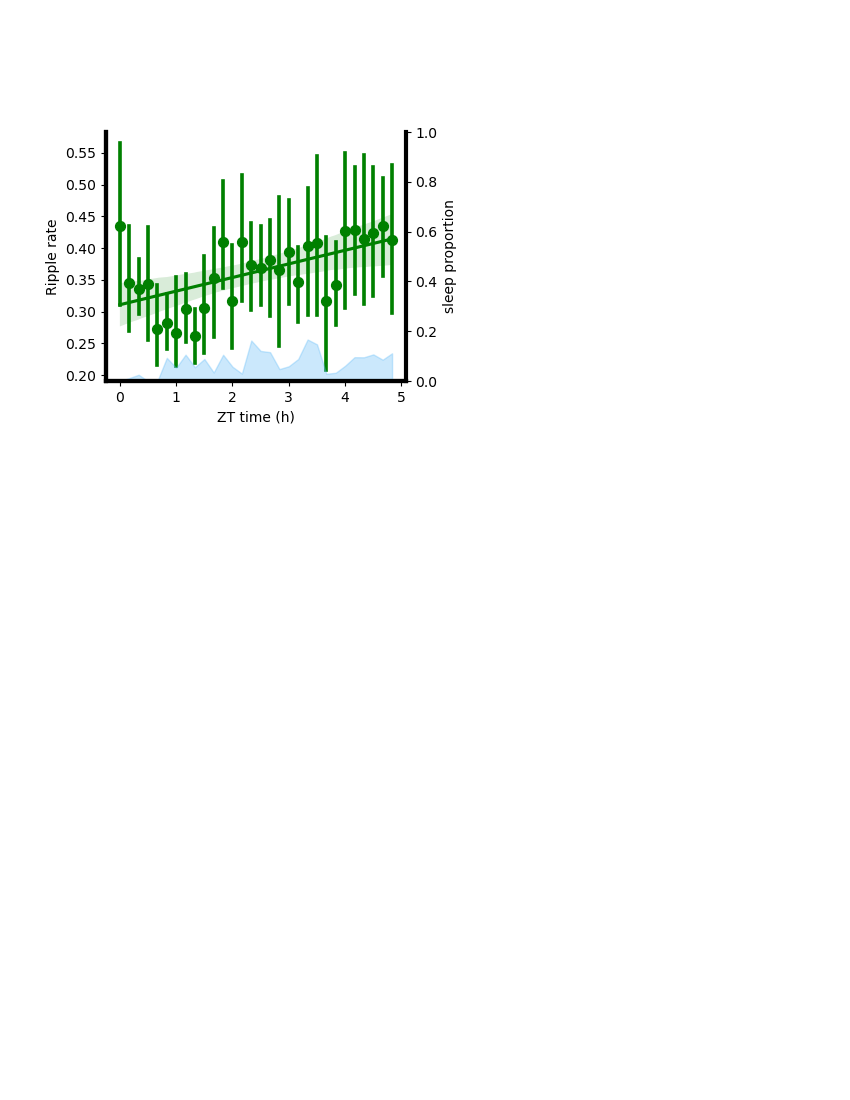

In [4]:
%matplotlib widget
figure = Fig()
fig, gs = figure.draw(grid=(3, 2), style="Pres")
df = pd.DataFrame()
for sub, sess in enumerate(sessions):

    post = sess.paradigm["post"].flatten()
    # pre = sess.paradigm.pre
    # sd_period = [post[0],post[1]]
    # sd_period = [post[0],post[0]+9*3600]
    # try:
    # sd_period = sess.paradigm['sd']
    # except:
    sd_period = [post[0], post[0] + 5 * 3600]
    rpls = sess.ripple
    # states = sess.brainstates.epochs

    binsz = 600
    sd_bin = np.arange(sd_period[0], sd_period[1] + binsz, binsz)
    hist_rpl = np.histogram(rpls.starts, bins=sd_bin)[0]

    nrem_percent = []
    for start in sd_bin[:-1]:
        prop = sess.brainstates.get_proportion_by_label(start, start + binsz)
        nrem_percent.append(prop["nrem"])

    df = df.append(
        pd.DataFrame(
            {
                "n_ripples": hist_rpl / binsz,
                "tbin": (sd_bin[:-1] - sd_bin[0]) / 3600,
                "nrem": nrem_percent,
                "sub": sub,
            }
        )
    )


ax = plt.subplot(gs[0])
rpls_mean = df.groupby("tbin").mean().n_ripples
rpls_sem = df.groupby("tbin").sem(ddof=0).n_ripples
# ax.fill_between(rpls_mean.index,rpls_mean-rpls_sem,rpls_mean+rpls_sem,color='#faa49d',alpha=0.6,ec=None)
sns.regplot(x="tbin", y="n_ripples", data=df, ax=ax, color="g", x_estimator=np.mean)
# ax.plot(rpls_mean.index,rpls_mean,color='#faa49d',zorder=2,lw=2)
# ax.axvline(5,ls='--',color='r')
ax.set_xlabel("ZT time (h)")
ax.set_ylabel("Ripple rate")


axsleep = ax.twinx()
color = "#54b6f8"
sleep_df = df.groupby("tbin").mean()
axsleep.fill_between(sleep_df.index, sleep_df.nrem, color=color, zorder=1, alpha=0.3)
# sns.lineplot(data=df,x='tbin',y='nrem',ax=axsleep,estimator='sum')
axsleep.set_ylim([0, 1])
axsleep.spines["right"].set_visible(True)
axsleep.set_ylabel("sleep proportion")

# --- individual sessions -------
# ax = plt.subplot(gs[2])
# # sns.lineplot(x='tbin',y='n_ripples',hue='sub',data=df,ax=ax,legend=None,palette='Blues')
# sns.lineplot(x='tbin',y='n_ripples',hue='sub',data=df,ax=ax,legend=None,palette='Blues')
# # sns.regplot(x='tbin',y='n_ripples',ci=68,data=df,ax=ax,color='g',x_estimator=np.mean,fit_reg=True)
# ax.set_xlabel('ZT time (h)')
# ax.set_ylabel('Ripple rate')


# axsleep= ax.twinx()
# color = sess.brainstates.colors['nrem']
# sleep_df = df.groupby('tbin').mean()
# axsleep.fill_between(sleep_df.index,sleep_df.nrem,color=color,zorder=1,alpha=0.3)
# # sns.lineplot(data=df,x='tbin',y='nrem',ax=axsleep,estimator='sum')
# axsleep.set_ylim([0,1])
# axsleep.spines['right'].set_visible(True)
# axsleep.set_ylabel('sleep proportion')
